In [1]:
import csv

import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
dataset = rasterio.open("./data/crs.tiff")
img_data = dataset.read(1)

In [3]:
with open('training/data_bin.csv', 'r') as f:
    reader = csv.DictReader(f)
    labeled_coords = [r for r in reader]
print("labeled dataset contains {} points".format(len(labeled_coords)))

labeled dataset contains 115 points


In [158]:
block_size = 32


def get_satellite_raw_uint8(coord):
    x, y = dataset.index(float(coord['lon']), float(coord['lat']))
    img = img_data[x - block_size // 2:x + block_size // 2, y - block_size // 2:y + block_size // 2]
    img = (img / np.max(img) * 255).astype(np.uint8)
    return img

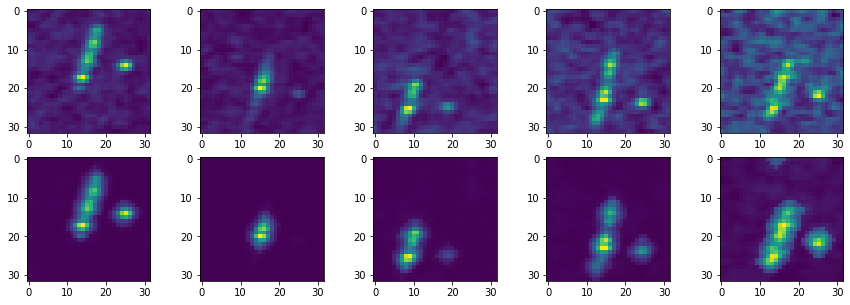

In [170]:
from matplotlib import pyplot as plt
from cv2 import cv2 as cv

f, axarr = plt.subplots(2, 5)
plt.rcParams['figure.figsize'] = [15, 5]

kernel1 = np.ones((3, 3), np.float32) / 25
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))


def remove_noise_satellite(img):
    mask = img / 16
    mask = np.power(mask, 2)
    mask = cv.filter2D(mask, -1, kernel1)
    avg_val = np.average(mask) + 10
    mask[mask < avg_val] = np.multiply(mask[mask < avg_val], 0.5)
    mask = cv.dilate(mask, kernel2, iterations=2)
    img = np.copy(img) * mask.astype(np.float32)
    img *= 255.0 / img.max()
    return img


for i in range(5):
    im_pre = get_satellite_raw_uint8(labeled_coords[75 + i])

    im = remove_noise_satellite(im_pre)
    axarr[0, i].imshow(im_pre)
    axarr[1, i].imshow(im)

In [160]:
def get_filtered_satellite_float32(coord):
    img = get_satellite_raw_uint8(coord)
    img = remove_noise_satellite(img)
    img = np.expand_dims(img, -1)
    return img

In [161]:
X = list(map(get_filtered_satellite_float32, labeled_coords))
Y = [int(l['windmill']) for l in labeled_coords]

In [162]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [163]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [164]:
model.fit(X_train, Y_train, epochs=5)

Epoch 1/5
3/3 [==============================] - 0s 9ms/step - loss: 7.0762 - accuracy: 0.4625
Epoch 2/5
3/3 [==============================] - 0s 8ms/step - loss: 2.0360 - accuracy: 0.8000
Epoch 3/5
3/3 [==============================] - 0s 9ms/step - loss: 1.2829 - accuracy: 0.8625
Epoch 4/5
3/3 [==============================] - 0s 8ms/step - loss: 1.9907 - accuracy: 0.8500
Epoch 5/5
3/3 [==============================] - 0s 8ms/step - loss: 1.0443 - accuracy: 0.8875


In [165]:
model.evaluate(X_test, Y_test, verbose=2)

2/2 - 0s - loss: 2.0797 - accuracy: 0.8571


[2.079692840576172, 0.8571428656578064]